# Plan

- files load
    - 각각의 csv 파일 확인
        - air 식당수
        - hpg 식당수

- preprocess
    - 하나의 파일로 만들기
        - 데이터의 id는 (위도, 경도)
        - 각각 reserve와 store_info 합치기
        - 하나의 csv 파일로 합치기 
        - 요일, holiday flag column 추가
        - 식당 genre, area column 추가 
        - air_visit_data 이용해서 워크인 count

    - feature 찾기
        - one-hot encoding (요일, 식당 genre, area)
        - 분포 확인 (로그 변환 사용)
        - 상관도 검색

- train
    - train : val = 8 : 2
    - 여러 모델 테스트 (앙상블 사용 예상)
    - 하이퍼 파라미터 조정
    - RMSLE 값 기준

- test
    - 케글측에서 일부러 연휴 기간을 포함, 식당이 열지 않은 날도 있지만 최종 점수에 포함 안됨
    - submission 파일 복사 후 날짜 분리, 사용할 feature append
    - 예측
    - submission 파일에 예측값 append
    - 제출

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os


In [2]:
# csv load
air_reserve_df = pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/air_reserve.csv.zip')
hpg_reserve_df = pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/hpg_reserve.csv.zip')
air_store_info_df = pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/air_store_info.csv.zip')
hpg_store_info_df = pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/hpg_store_info.csv.zip')
store_id_relation_df = pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/store_id_relation.csv.zip')
date_info_df = pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/date_info.csv.zip')
air_visit_data_df = pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/air_visit_data.csv.zip')
sample_submission_df = pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/sample_submission.csv.zip')

In [3]:
print("air의 예약된 식당 수: ", len(air_reserve_df['air_store_id'].unique()))
air_reserve_df.head()

air의 예약된 식당 수:  314


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [4]:
print("air에 정보가 있는 식당 수: ", len(air_store_info_df['air_store_id'].unique()))
air_store_info_df.head()

air에 정보가 있는 식당 수:  829


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [5]:
print("hpg의 예약된 식당 수: ", len(hpg_reserve_df['hpg_store_id'].unique()))
hpg_reserve_df.head()

hpg의 예약된 식당 수:  13325


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [6]:
print("hpg에 정보가 있는 식당 수: ", len(hpg_store_info_df['hpg_store_id'].unique()))
hpg_store_info_df.head()

hpg에 정보가 있는 식당 수:  4690


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [7]:
print("air와 hpg가 맴핑되어 있는 수: ", len(store_id_relation_df))
store_id_relation_df.head()

air와 hpg가 맴핑되어 있는 수:  150


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [8]:
date_info_df.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [9]:
air_visit_data_df.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [10]:
sample_submission_df.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


#### 정리

air의 예약된 식당 수:  314
air에 정보가 있는 식당 수:  829
hpg의 예약된 식당 수:  13325
hpg에 정보가 있는 식당 수:  4690
air와 hpg가 맴핑되어 있는 수:  150

hpg가 가지고 있는 식당 정보에 비해 예약된 식당수가 너무나 많다. 따라서 예약된 식당들 중 정보가 없는 것들이 많기 때문에 정보가 있는 hpg 식당만 추출해야 한다. 그리고 air와 hpg 각각의 식당 수에 비해 맴핑되어 있는 수가 적기 때문에 이 정보는 필요없다. 

## preprocess

### 하나의 csv로 만들기

In [11]:
# air 예약정보와 가게정보 합치기
air_mixed_df = pd.merge(air_reserve_df, air_store_info_df)
# air_mixed_df.head()
# len(air_mixed_df)

In [12]:
hpg_mixed_df = pd.merge(hpg_reserve_df, hpg_store_info_df)
hpg_mixed_df.head()
# print(len(hpg_reserve_df))
# print(len(hpg_mixed_df))

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
3,hpg_dac72789163a3f47,2016-01-06 12:00:00,2016-01-06 08:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
4,hpg_dac72789163a3f47,2016-01-10 17:00:00,2016-01-04 22:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


In [13]:
# column name 공통되게 변경
air_mixed_new_columns_df = air_mixed_df.rename(columns = {"air_store_id":"id", "air_genre_name":"genre", "air_area_name": "area_name"}, inplace = False)
hpg_mixed_new_columns_df = hpg_mixed_df.rename(columns = {"hpg_store_id":"id", "hpg_genre_name":"genre", "hpg_area_name": "area_name"}, inplace = False)
mixed_df = pd.concat([air_mixed_new_columns_df, hpg_mixed_new_columns_df])
mixed_df

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619


In [14]:
# visit_datetime을 년월일로 변경
mixed_cp_df = mixed_df.copy()
mixed_cp_df['visit_date'] = mixed_cp_df['visit_datetime'].str.slice(start=0, stop=10)
# mixed_cp_df= mixed_cp_df.drop(['id', 'visit_datetime', 'reserve_datetime'], axis='columns')
mixed_cp_df

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-01
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-01
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-02
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-02
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-08
...,...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24


In [15]:
# 같은 날, 같은 식당의 reserve_visitors 합치기
merged_df = mixed_cp_df.groupby(by=['visit_date','latitude','longitude','genre','area_name', 'id'], as_index=False).sum()
merged_df

,visit_date,latitude,longitude,genre,area_name,id,reserve_visitors
0,2016-01-01,33.556881,130.415134,Seafood,Fukuoka-ken Fukuoka-shi None,hpg_a508a4e8b427279a,6
1,2016-01-01,33.576379,130.339313,Japanese style,Fukuoka-ken Fukuoka-shi Minamishō,hpg_b7f05c204af42b91,6
2,2016-01-01,33.576379,130.339313,Japanese style,Fukuoka-ken Fukuoka-shi Minamishō,hpg_f802d9079d5b1af3,2
3,2016-01-01,33.579734,130.401762,International cuisine,Fukuoka-ken Fukuoka-shi Ōmiya,hpg_962b3ed9f41e5b63,2
4,2016-01-01,33.586969,130.392801,Grilled meat,Fukuoka-ken Fukuoka-shi Daimyō,hpg_f6117f6d2533237f,2
...,...,...,...,...,...,...,...
590934,2017-05-31,35.682504,139.773619,Seafood,Tōkyō-to Chūō-ku None,hpg_77d300f2b1f22a8a,8
590935,2017-05-31,35.691384,139.701256,Spain Bar/Italian Bar,Tōkyō-to Shinjuku-ku None,hpg_ba19e6108767ebb6,4
590936,2017-05-31,35.691384,139.701256,Steak/Hamburger/Curry,Tōkyō-to Shinjuku-ku None,hpg_2bc4e1cbe5cd308b,1
590937,2017-05-31,35.695780,139.768453,International cuisine,Tōkyō-to Chiyoda-ku None,hpg_24bce7c3238bdd5c,40


In [16]:
# 요일과 holiday flag 추가하기
merged_with_day_df = pd.merge(merged_df, date_info_df, left_on='visit_date', right_on='calendar_date')
merged_with_day_df

,visit_date,latitude,longitude,genre,area_name,id,reserve_visitors,calendar_date,day_of_week,holiday_flg
0,2016-01-01,33.556881,130.415134,Seafood,Fukuoka-ken Fukuoka-shi None,hpg_a508a4e8b427279a,6,2016-01-01,Friday,1
1,2016-01-01,33.576379,130.339313,Japanese style,Fukuoka-ken Fukuoka-shi Minamishō,hpg_b7f05c204af42b91,6,2016-01-01,Friday,1
2,2016-01-01,33.576379,130.339313,Japanese style,Fukuoka-ken Fukuoka-shi Minamishō,hpg_f802d9079d5b1af3,2,2016-01-01,Friday,1
3,2016-01-01,33.579734,130.401762,International cuisine,Fukuoka-ken Fukuoka-shi Ōmiya,hpg_962b3ed9f41e5b63,2,2016-01-01,Friday,1
4,2016-01-01,33.586969,130.392801,Grilled meat,Fukuoka-ken Fukuoka-shi Daimyō,hpg_f6117f6d2533237f,2,2016-01-01,Friday,1
...,...,...,...,...,...,...,...,...,...,...
590934,2017-05-31,35.682504,139.773619,Seafood,Tōkyō-to Chūō-ku None,hpg_77d300f2b1f22a8a,8,2017-05-31,Wednesday,0
590935,2017-05-31,35.691384,139.701256,Spain Bar/Italian Bar,Tōkyō-to Shinjuku-ku None,hpg_ba19e6108767ebb6,4,2017-05-31,Wednesday,0
590936,2017-05-31,35.691384,139.701256,Steak/Hamburger/Curry,Tōkyō-to Shinjuku-ku None,hpg_2bc4e1cbe5cd308b,1,2017-05-31,Wednesday,0
590937,2017-05-31,35.695780,139.768453,International cuisine,Tōkyō-to Chiyoda-ku None,hpg_24bce7c3238bdd5c,40,2017-05-31,Wednesday,0


In [17]:
# genre 값 확인
merged_with_day_df['genre'].unique()

array(['Seafood', 'Japanese style', 'International cuisine',
       'Grilled meat', 'Italian', 'Dining bar', 'French',
       'Spain Bar/Italian Bar', 'Okonomiyaki/Monja/Teppanyaki',
       'Japanese cuisine/Kaiseki', 'Japanese food', 'Creation',
       'Japanese food in general', 'Shabu-shabu/Sukiyaki', 'Izakaya',
       'Chinese general', 'Creative Japanese food', 'Sushi',
       'Steak/Hamburger/Curry', 'Bistro', 'Udon/Soba', 'Italian/French',
       'Korean cuisine', 'Sweets', 'Karaoke', 'Bar/Cocktail',
       'Cafe/Sweets', 'Cafe', 'Thai/Vietnamese food', 'Pasta/Pizza',
       'Western food', 'Yakiniku/Korean food', 'Party', 'Amusement bar',
       'Cantonese food', 'Sichuan food', 'Shanghai food',
       'Spain/Mediterranean cuisine', 'Dim Sum/Dumplings',
       'Taiwanese/Hong Kong cuisine', 'Other', 'Creative cuisine',
       'Karaoke/Party', 'Asian'], dtype=object)

In [18]:
# area_name none 확인
merged_with_day_df['area_name'].unique()

array(['Fukuoka-ken Fukuoka-shi None',
       'Fukuoka-ken Fukuoka-shi Minamishō',
       'Fukuoka-ken Fukuoka-shi Ōmiya', 'Fukuoka-ken Fukuoka-shi Daimyō',
       'None None None', 'Fukuoka-ken Kitakyūshū-shi Sunatsu',
       'Hiroshima-ken Fukuyama-shi Sannomaruchō',
       'Ōsaka-fu Higashiōsaka-shi Wakaenishishinmachi',
       'Ōsaka-fu Ōsaka-shi Shinsaibashisuji',
       'Ōsaka-fu Ōsaka-shi Shinmachi', 'Hyōgo-ken Kōbe-shi None',
       'Ōsaka-fu Ōsaka-shi None', 'Ōsaka-fu Ōsaka-shi Nakanochō',
       'Osaka Prefecture Osaka None', 'Ōsaka-fu Suita-shi Enokichō',
       'Hyōgo-ken Kakogawa-shi Noguchichō Yoshino',
       'Ōsaka-fu Takatsuki-shi Kamitanabechō',
       'Shizuoka-ken Shizuoka-shi Hinodechō',
       'Shizuoka-ken Shizuoka-shi Irie',
       'Shizuoka-ken Numazu-shi Yanagisawa',
       'Tōkyō-to Machida-shi Nakamachi',
       'Tōkyō-to Shinagawa-ku Yutakachō', 'Tōkyō-to Tama-shi Tsurumaki',
       'Tōkyō-to Minato-ku Takanawa', 'Tōkyō-to Shibuya-ku Ebisunishi',
       'Tō

In [19]:
# air_visit_data 이용해서 워크인, 노쇼 등 확인
check_no_show_df = pd.merge(air_visit_data_df, merged_with_day_df, left_on=['air_store_id', 'visit_date'], right_on=['id','visit_date'])
check_no_show2_df = check_no_show_df.drop(['id', 'latitude', 'longitude', 'genre', 'area_name', 'calendar_date', 'day_of_week', 'holiday_flg'], axis='columns')
check_no_show2_df

,air_store_id,visit_date,visitors,reserve_visitors
0,air_35512c42db0868da,2016-02-27,6,12
1,air_ee3a01f0c71a769f,2016-01-04,61,2
2,air_ee3a01f0c71a769f,2016-01-08,21,3
3,air_ee3a01f0c71a769f,2016-01-09,57,25
4,air_ee3a01f0c71a769f,2016-01-10,32,5
...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,2
28060,air_754ae581ad80cc9f,2017-04-15,39,20
28061,air_754ae581ad80cc9f,2017-04-19,6,6
28062,air_754ae581ad80cc9f,2017-04-22,47,28


In [20]:
# 노쇼와 워크인의 비중이 큰듯하여 예약에 관한 내용을 신경쓰지 않기로 함
temp_df = check_no_show_df.drop(['id', 'calendar_date'], axis='columns')
temp_df

,air_store_id,visit_date,visitors,latitude,longitude,genre,area_name,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,35.717784,139.566260,Dining bar,Tōkyō-to Musashino-shi Midorichō,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,34.710895,137.725940,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,34.710895,137.725940,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,3,Friday,0
3,air_ee3a01f0c71a769f,2016-01-09,57,34.710895,137.725940,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,25,Saturday,0
4,air_ee3a01f0c71a769f,2016-01-10,32,34.710895,137.725940,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,5,Sunday,0
...,...,...,...,...,...,...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,37.874223,138.971940,Izakaya,Niigata-ken Niigata-shi Teraohigashi,2,Friday,0
28060,air_754ae581ad80cc9f,2017-04-15,39,37.874223,138.971940,Izakaya,Niigata-ken Niigata-shi Teraohigashi,20,Saturday,0
28061,air_754ae581ad80cc9f,2017-04-19,6,37.874223,138.971940,Izakaya,Niigata-ken Niigata-shi Teraohigashi,6,Wednesday,0
28062,air_754ae581ad80cc9f,2017-04-22,47,37.874223,138.971940,Izakaya,Niigata-ken Niigata-shi Teraohigashi,28,Saturday,0


In [21]:
# area_name none 확인
# temp_df['area_name'].unique()
temp_df['area_name'].value_counts(ascending=True)

Hyōgo-ken Takarazuka-shi Tōyōchō                  1
Tōkyō-to Taitō-ku Asakusa                         1
Tōkyō-to Musashino-shi Midorichō                  1
Hyōgo-ken Amagasaki-shi Higashinanamatsuchō       1
Hyōgo-ken Kōbe-shi Motomachidōri                  1
                                               ... 
Shizuoka-ken Hamamatsu-shi Motoshirochō        1349
Hokkaidō Sapporo-shi Minami 3 Jōnishi          1421
Hiroshima-ken Hiroshima-shi Kokutaijimachi     1710
Fukuoka-ken Fukuoka-shi Daimyō                 1801
Tōkyō-to Shibuya-ku Shibuya                    2158
Name: area_name, Length: 71, dtype: int64

In [22]:
# genre 값 확인
# temp_df['genre'].unique()
temp_df['genre'].value_counts(ascending=True)

Asian                              1
International cuisine              3
Karaoke/Party                     43
Other                            248
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [23]:
# genre 통합
final_df = temp_df.copy()
final_df['genre'] = final_df['genre'].replace('Asian', 'Other')
final_df['genre'] = final_df['genre'].replace('International cuisine', 'Other')
# final_df['genre'].value_counts(ascending=True)
final_df

,air_store_id,visit_date,visitors,latitude,longitude,genre,area_name,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,35.717784,139.566260,Dining bar,Tōkyō-to Musashino-shi Midorichō,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,34.710895,137.725940,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,34.710895,137.725940,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,3,Friday,0
3,air_ee3a01f0c71a769f,2016-01-09,57,34.710895,137.725940,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,25,Saturday,0
4,air_ee3a01f0c71a769f,2016-01-10,32,34.710895,137.725940,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,5,Sunday,0
...,...,...,...,...,...,...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,37.874223,138.971940,Izakaya,Niigata-ken Niigata-shi Teraohigashi,2,Friday,0
28060,air_754ae581ad80cc9f,2017-04-15,39,37.874223,138.971940,Izakaya,Niigata-ken Niigata-shi Teraohigashi,20,Saturday,0
28061,air_754ae581ad80cc9f,2017-04-19,6,37.874223,138.971940,Izakaya,Niigata-ken Niigata-shi Teraohigashi,6,Wednesday,0
28062,air_754ae581ad80cc9f,2017-04-22,47,37.874223,138.971940,Izakaya,Niigata-ken Niigata-shi Teraohigashi,28,Saturday,0


In [53]:
import folium

df = final_df.loc[:, ['air_store_id', 'genre', 'latitude', 'longitude']]
df = df.drop_duplicates()
df.reset_index(inplace=True)


#지도 띄우기 (지도의 중심을 지정하기 위해 위도와 경도의 평균 구하기)
map = folium.Map([df['latitude'].mean(),df['longitude'].mean()],zoom_start=7)

for i in df.index:
    sub_lat =  df.loc[i,'latitude']
    sub_long = df.loc[i,'longitude']
    
    title1 = df.loc[i, 'air_store_id']
    title2 = df.loc[i,'genre']
    #지도에 데이터 찍어서 보여주기
    folium.Marker([sub_lat,sub_long], popup = title1+'\n'+title2).add_to(map)

#한글이 안나오는 오류로 html로 trouble shooting 
map.save('map.html')
map

### Feature 찾기

In [24]:
# file load
file_df = final_df.copy()
target_name = 'visitors'
no_need_features = ['air_store_id', 'visit_date']
category_features = ['genre', 'area_name', 'day_of_week', 'holiday_flg']

In [25]:
# arrange X and y
file_df.drop(no_need_features, axis=1, inplace=True)
y_target = file_df[target_name]
X_features = file_df.drop([target_name],axis=1,inplace=False)

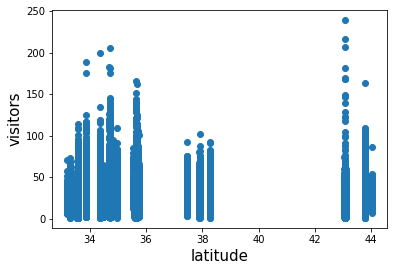

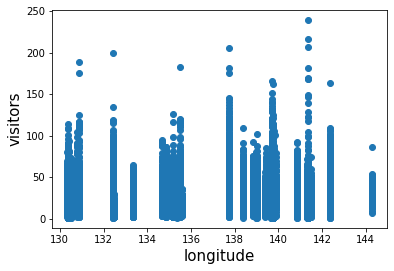

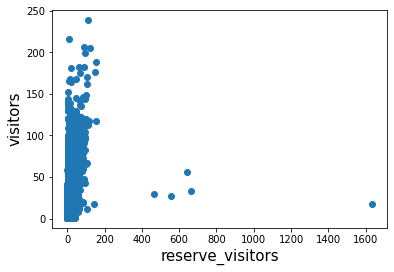

In [26]:
# visualize data to find outliers
for feature in X_features.drop(category_features, axis=1, inplace=False):
    plt.scatter(x = file_df[feature], y = y_target)
    plt.ylabel(target_name, fontsize=15)
    plt.xlabel(feature, fontsize=15)
    plt.show()

In [27]:
# remove outlier
outlier_name = 'reserve_visitors'
cond1 = file_df[outlier_name] > 400
outlier_index = X_features[cond1].index
print('Outlier index :', outlier_index.values)
print('X_feature shape before Outlier is removed:', X_features.shape)
X_features.drop(outlier_index , axis=0, inplace=True)
y_target.drop(outlier_index, axis=0, inplace=True)
print('X_feature shape after Outlier is removed:', X_features.shape)

Outlier index : [ 2601  2602  2603  2604 12225]
X_feature shape before Outlier is removed: (28064, 7)
X_feature shape after Outlier is removed: (28059, 7)


In [28]:
# figure out the extent of distortion in features --> if the degree of distortion is high(>1 or <-1), log transformation is performed.
non_category_features_index = X_features.drop(category_features, axis=1, inplace=False).dtypes.index
skew_features = X_features[non_category_features_index].apply(lambda x : skew(x))
print(skew_features.sort_values(ascending=False))

skew_features_need_change = skew_features
X_features[skew_features_need_change.index] = np.log1p(X_features[skew_features_need_change.index])
X_features

reserve_visitors    2.075505
latitude            1.785027
longitude          -0.586010
dtype: float64


,latitude,longitude,genre,area_name,reserve_visitors,day_of_week,holiday_flg
0,3.603261,4.945679,Dining bar,Tōkyō-to Musashino-shi Midorichō,2.564949,Saturday,0
1,3.575456,4.932500,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,1.098612,Monday,0
2,3.575456,4.932500,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,1.386294,Friday,0
3,3.575456,4.932500,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,3.258097,Saturday,0
4,3.575456,4.932500,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,1.791759,Sunday,0
...,...,...,...,...,...,...,...
28059,3.660331,4.941442,Izakaya,Niigata-ken Niigata-shi Teraohigashi,1.098612,Friday,0
28060,3.660331,4.941442,Izakaya,Niigata-ken Niigata-shi Teraohigashi,3.044522,Saturday,0
28061,3.660331,4.941442,Izakaya,Niigata-ken Niigata-shi Teraohigashi,1.945910,Wednesday,0
28062,3.660331,4.941442,Izakaya,Niigata-ken Niigata-shi Teraohigashi,3.367296,Saturday,0


In [29]:
# sample_submission 데이터 전처리
# sample_submission_df.head()
temp_df = sample_submission_df.copy()
temp_df['store_id'] = temp_df['id'].str.slice(start=0, stop=20)
temp_df['date'] = temp_df['id'].str.slice(start=21, stop=31)
temp_df = temp_df.drop(['visitors'], axis='columns')
# temp_df

In [30]:
temp2_df = pd.merge(temp_df, date_info_df, left_on='date', right_on='calendar_date')
temp2_df = temp2_df.drop(['date', 'calendar_date'], axis='columns')

temp3_df = pd.merge(temp2_df, air_store_info_df, left_on='store_id', right_on='air_store_id')
temp3_df = temp3_df.drop(['air_store_id', 'store_id'], axis='columns')
temp3_df = temp3_df.rename(columns = {"air_genre_name":"genre", "air_area_name": "area_name"}, inplace = False)
temp3_df['genre'] = temp3_df['genre'].replace('Asian', 'Other')
temp3_df['genre'] = temp3_df['genre'].replace('International cuisine', 'Other')
temp3_df = temp3_df.sort_values(by=['id'], axis=0)
temp3_df

,id,day_of_week,holiday_flg,genre,area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,Sunday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_00a91d42b08b08d9_2017-04-24,Monday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
2,air_00a91d42b08b08d9_2017-04-25,Tuesday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
3,air_00a91d42b08b08d9_2017-04-26,Wednesday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
4,air_00a91d42b08b08d9_2017-04-27,Thursday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,Saturday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288
32015,air_fff68b929994bfbd_2017-05-28,Sunday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288
32016,air_fff68b929994bfbd_2017-05-29,Monday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288
32017,air_fff68b929994bfbd_2017-05-30,Tuesday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288


In [31]:
# if the log transformation is applied, the target column also needs to be normal distribution
y_target_log = np.log1p(y_target)
print(y_target)
print(y_target_log)

0         6
1        61
2        21
3        57
4        32
         ..
28059     3
28060    39
28061     6
28062    47
28063    20
Name: visitors, Length: 28059, dtype: int64
0        1.945910
1        4.127134
2        3.091042
3        4.060443
4        3.496508
           ...   
28059    1.386294
28060    3.688879
28061    1.945910
28062    3.871201
28063    3.044522
Name: visitors, Length: 28059, dtype: float64


In [32]:
# test file 값 정규화
category_features.append('id')
non_category_features_index = temp3_df.drop(category_features, axis=1, inplace=False).dtypes.index
skew_features = temp3_df[non_category_features_index].apply(lambda x : skew(x))
print(skew_features.sort_values(ascending=False))
skew_features_need_change = skew_features
temp3_df[skew_features_need_change.index] = np.log1p(temp3_df[skew_features_need_change.index])
temp3_df

latitude     2.684234
longitude   -0.934611
dtype: float64


,id,day_of_week,holiday_flg,genre,area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,Sunday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,3.602613,4.947011
1,air_00a91d42b08b08d9_2017-04-24,Monday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,3.602613,4.947011
2,air_00a91d42b08b08d9_2017-04-25,Tuesday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,3.602613,4.947011
3,air_00a91d42b08b08d9_2017-04-26,Wednesday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,3.602613,4.947011
4,air_00a91d42b08b08d9_2017-04-27,Thursday,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,3.602613,4.947011
...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,Saturday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,3.602999,4.946390
32015,air_fff68b929994bfbd_2017-05-28,Sunday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,3.602999,4.946390
32016,air_fff68b929994bfbd_2017-05-29,Monday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,3.602999,4.946390
32017,air_fff68b929994bfbd_2017-05-30,Tuesday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,3.602999,4.946390


In [33]:
# X_features와 submission file concat
frames = [X_features, temp3_df]
concated_df = pd.concat(frames, keys=['x','y'])
concated_df

latitude  longitude         genre  \
x 0      3.603261   4.945679    Dining bar   
  1      3.575456   4.932500   Cafe/Sweets   
  2      3.575456   4.932500   Cafe/Sweets   
  3      3.575456   4.932500   Cafe/Sweets   
  4      3.575456   4.932500   Cafe/Sweets   
...           ...        ...           ...   
y 32014  3.602999   4.946390  Bar/Cocktail   
  32015  3.602999   4.946390  Bar/Cocktail   
  32016  3.602999   4.946390  Bar/Cocktail   
  32017  3.602999   4.946390  Bar/Cocktail   
  32018  3.602999   4.946390  Bar/Cocktail   

                                       area_name  reserve_visitors  \
x 0             Tōkyō-to Musashino-shi Midorichō          2.564949   
  1      Shizuoka-ken Hamamatsu-shi Motoshirochō          1.098612   
  2      Shizuoka-ken Hamamatsu-shi Motoshirochō          1.386294   
  3      Shizuoka-ken Hamamatsu-shi Motoshirochō          3.258097   
  4      Shizuoka-ken Hamamatsu-shi Motoshirochō          1.791759   
...                                          ...               ...   
y 32014                Tōkyō-to Nakano-ku Nakano               NaN   
  32015                Tōkyō-to Nakano-ku Nakano               NaN   
  32016                Tōkyō-to Nakano-ku Nakano               NaN   
  32017                Tōkyō-to Nakano-ku Nakano               NaN   
  32018                Tōkyō-to Nakano-ku Nakano               NaN   

        day_of_week  holiday_flg                               id  
x 0        Saturday            0                              NaN  
  1          Monday            0                              NaN  
  2          Friday            0                              NaN  
  3        Saturday            0                              NaN  
  4          Sunday            0                              NaN  
...             ...          ...                              ...  
y 32014    Saturday            0  air_fff68b929994bfbd_2017-05-27  
  32015      Sunday            0  air_fff68b929994bfbd_2017-05-28  
  32016      Monday            0  air_fff68b929994bfbd_2017-05-29  
  32017     Tuesday            0  air_fff68b929994bfbd_2017-05-30  
  32018   Wednesday            0  air_fff68b929994bfbd_2017-05-31  

[60078 rows x 8 columns]

In [34]:
# change the category feature to One-Hot Encoding
category_features = ['genre', 'area_name', 'day_of_week', 'holiday_flg']
ohe_df = pd.get_dummies(concated_df, columns=category_features)
X_features_ohe = ohe_df.loc['x']
X_features_ohe = X_features_ohe.drop(['id'], axis='columns')
test_x_df = ohe_df.loc['y'].drop(['reserve_visitors'], axis='columns')
test_x_df = test_x_df.sort_values(by=['id'], axis=0)
test_x_df

,latitude,longitude,id,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,...,area_name_Ōsaka-fu Ōsaka-shi Ōhiraki,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-23,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-24,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-26,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
4,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-27,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,3.602999,4.946390,air_fff68b929994bfbd_2017-05-27,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
32015,3.602999,4.946390,air_fff68b929994bfbd_2017-05-28,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
32016,3.602999,4.946390,air_fff68b929994bfbd_2017-05-29,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
32017,3.602999,4.946390,air_fff68b929994bfbd_2017-05-30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


## Train

In [35]:
# declare the model
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
en_reg = ElasticNet()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
gbm_reg = GradientBoostingRegressor()
xgb_reg = XGBRegressor()
# lgbm_reg = LGBMRegressor()

In [36]:
def get_best_params(model, params, X, y):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_log_error', cv=5)
    grid_model.fit(X, y)
    rmsle = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV best average RMSLE value: {1}, best alpha:{2}'.format(model.__class__.__name__,np.round(rmsle, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [37]:
# find best parameters
# ridge_params = { 'alpha':[130, 150, 170]}
# lasso_params = { 'alpha':[0.003, 0.004, 0.005]}
# en_params = { 'alpha':[0.001, 0.005, 0.01, 0.05, 0.07, 0.1]}
# dt_params = {'max_depth':[1,2,3,4,5,6]}
#rf_params = {'n_estimators':[200], 'max_depth' : [5], 'min_samples_leaf' : [2], 'min_samples_split' : [5]}

# gbm_params = {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators':[100, 500, 700], 'subsample': [0.01, 0.05, 0.1]}
# xgb_params = {'colsample_bytree': [1], 'eta': [0.1], 'max_depth': [3], 'min_child_weight': [3], 'n_estimators':[120]}

# best_rige = get_best_params(ridge_reg, ridge_params, X_features_ohe, y_target_log)
# best_lasso = get_best_params(lasso_reg, lasso_params, X_features_ohe, y_target_log)
# best_en = get_best_params(en_reg, en_params, X_features_ohe, y_target_log)
# best_dt = get_best_params(dt_reg, dt_params, X_features_ohe, y_target_log)
# best_rf = get_best_params(rf_reg, rf_params, X_features_ohe, y_target_log)

# best_gbm = get_best_params(gbm_reg, gbm_params, X_features_ohe, y_target_log)
# best_xgb = get_best_params(xgb_reg, xgb_params, X_features_ohe, y_target_log)

In [38]:
# define the model
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=170)
lasso_reg = Lasso(alpha=0.004)
en_reg = ElasticNet(alpha=0.01)
dt_reg = DecisionTreeRegressor(max_depth=4)
rf_reg = RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_jobs=-1)
gbm_reg = GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)
xgb_reg = XGBRegressor(eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)
# lgbm_reg = LGBMRegressor(learning_rate=0.03, max_depth=3, min_child_samples=10, n_estimators=1000, num_leaves=3)

In [39]:
# split train/test data based on feature dataset with One-Hot encoding
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.2, random_state=0)

In [40]:
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    # scale back by expm1() if the predicted result is predicted by log-translated data
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
    print('\n###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    
# calculate MAE, MSE, RMSE, RMSLE
def evaluate_regr(y, pred):
    mae_val = mean_absolute_error(y, pred)
    mse_val = mean_squared_error(y, pred)
    rmse_val = rmse(y, pred)
    rmsle_val = rmsle(y,pred)
    r2_val = r2_score(y, pred)
    print('MAE: {0:.3F}, MSE: {1:.3F}, RMSE: {2:.3F}, RMSLE: {3:.3F}, R2: {4:.3F}'.format(mae_val, mse_val, rmse_val, rmsle_val, r2_val))

# calculate RMSLE using log1p(), not log() because of the NaN issue 
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# calculate RMSE using mean_square_error() of Scikit-learn 
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

In [41]:
# linear regression models
models_linear = [lr_reg, ridge_reg, lasso_reg, en_reg]
for model in models_linear:
    get_model_predict(model,X_train, X_test, y_train, y_test)


### LinearRegression ###
MAE: 8.829, MSE: 167.135, RMSE: 12.928, RMSLE: 0.493, R2: 0.486

### Ridge ###
MAE: 8.905, MSE: 171.757, RMSE: 13.106, RMSLE: 0.500, R2: 0.472

### Lasso ###
MAE: 9.169, MSE: 182.089, RMSE: 13.494, RMSLE: 0.517, R2: 0.440

### ElasticNet ###
MAE: 9.252, MSE: 185.537, RMSE: 13.621, RMSLE: 0.521, R2: 0.429


In [42]:
# regression tree models
models_tree = [dt_reg, rf_reg, gbm_reg, xgb_reg]
# models_tree = [dt_reg]
for model in models_tree:
    get_model_predict(model,X_train, X_test, y_train, y_test)


### DecisionTreeRegressor ###
MAE: 9.518, MSE: 197.938, RMSE: 14.069, RMSLE: 0.540, R2: 0.391

### RandomForestRegressor ###
MAE: 9.250, MSE: 188.834, RMSE: 13.742, RMSLE: 0.526, R2: 0.419

### GradientBoostingRegressor ###
MAE: 8.362, MSE: 158.378, RMSE: 12.585, RMSLE: 0.474, R2: 0.513

### XGBRegressor ###
MAE: 8.435, MSE: 161.970, RMSE: 12.727, RMSLE: 0.478, R2: 0.502


## Test

In [43]:
test_x_df

,latitude,longitude,id,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,...,area_name_Ōsaka-fu Ōsaka-shi Ōhiraki,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-23,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-24,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-26,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
4,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-27,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,3.602999,4.946390,air_fff68b929994bfbd_2017-05-27,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
32015,3.602999,4.946390,air_fff68b929994bfbd_2017-05-28,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
32016,3.602999,4.946390,air_fff68b929994bfbd_2017-05-29,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
32017,3.602999,4.946390,air_fff68b929994bfbd_2017-05-30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [44]:
x_temp_features = X_features_ohe.drop(['reserve_visitors'], axis='columns')
x_temp_features

,latitude,longitude,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,...,area_name_Ōsaka-fu Ōsaka-shi Ōhiraki,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.603261,4.945679,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,3.575456,4.932500,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3.575456,4.932500,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,3.575456,4.932500,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,3.575456,4.932500,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28059,3.660331,4.941442,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
28060,3.660331,4.941442,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
28061,3.660331,4.941442,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
28062,3.660331,4.941442,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [45]:
test_x2_df = test_x_df.set_index('id',inplace = False)
test_x2_df

,latitude,longitude,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,...,area_name_Ōsaka-fu Ōsaka-shi Ōhiraki,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9_2017-04-23,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
air_00a91d42b08b08d9_2017-04-24,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
air_00a91d42b08b08d9_2017-04-25,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
air_00a91d42b08b08d9_2017-04-26,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
air_00a91d42b08b08d9_2017-04-27,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
air_fff68b929994bfbd_2017-05-27,3.602999,4.946390,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
air_fff68b929994bfbd_2017-05-28,3.602999,4.946390,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
air_fff68b929994bfbd_2017-05-29,3.602999,4.946390,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [46]:
# model define
# model = Ridge(alpha=170)
# model.fit(x_temp_features, y_target)

In [47]:
# predict
# predict_value = model.predict(test_x2_df)
# print("**Single Model**")
# test_y = []
# for x in predict_value:
#     test_y.append(round(x,1))
# final_sub_df = sample_submission_df.copy()
# final_sub_df['visitors'] = test_y
# final_sub_df

In [48]:
# mixed model
model1 = LinearRegression()
model2 = gbm_reg = GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)
# model3 = xgb_reg = XGBRegressor(eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)

model1.fit(x_temp_features, y_target)
model2.fit(x_temp_features, y_target)
# model3.fit(x_temp_features, y_target)

GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)

In [49]:
# mixed model
pred1 = model1.predict(test_x2_df)
pred2 = model2.predict(test_x2_df)

pred = pred2
test_y2 = []
for x in pred:
    test_y2.append(round(x,3))

final_sub_df = sample_submission_df.copy()
final_sub_df['visitors'] = test_y2
final_sub_df

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,29.659
1,air_00a91d42b08b08d9_2017-04-24,23.173
2,air_00a91d42b08b08d9_2017-04-25,24.387
3,air_00a91d42b08b08d9_2017-04-26,26.219
4,air_00a91d42b08b08d9_2017-04-27,25.492
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,28.987
32015,air_fff68b929994bfbd_2017-05-28,24.472
32016,air_fff68b929994bfbd_2017-05-29,15.678
32017,air_fff68b929994bfbd_2017-05-30,17.135


In [50]:
final_sub_df.to_csv('/aiffel/aiffel/Hackerton/1/submission.csv', sep=',', index = False)

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/Hackerton/1/submission.csv'